# ORF recognition by Convolutional/Recurrent

Explore how to connect Dense layer after a LSTM layer.

Should there be a Flatten layer between them?

Should the last LSTM use return_sequences True or False?

Should the first Dense layer have a TimeDistributed wrapper? What about subsequent Dense layers?

In [ ]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-25 18:56:06 UTC'

In [ ]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=32            # how long is each sequence
CDS_LEN=16            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=50  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [ ]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [ ]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [ ]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 45 trials to reach 10 per class.
It took 143285 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [ ]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 32.0
Average ORF length: 19.68690909090909
NC seqs
Average RNA length: 32.0
Average ORF length: 2.875


In [ ]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [ ]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [ ]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    #dnn.add(TimeDistributed(Dense(NEURONS,activation="sigmoid",dtype=np.float32)))   
    #dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    #dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    #dnn.build(input_shape=INPUT_SHAPE)   
    dnn.build()   
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (32, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 32, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 16, 16)            2112      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 5,233
Trainable params: 5,233
Non-trainable params: 0
________________________

LSTM(16,return_sequences=False), Dense(15) has 255 parameters. Acc=52%. Output shape is (None, 1). Output layer has 65 parameters: 8 * 8 + 1 so clearly it has one neuron.

LSTM(16,return_sequences=True), TimeDistributed(Dense(15)) has 255 parameters. Acc=65%. AUC fails because dimensions are wrong. Output shape is (None, 8, 1). The 8 is inherited from the Pooling layer and it is the revised sequence length. Output layer has 16 parameters: 8 + 8 so it seems to have 8 neurons despite parameter value 1. It seems the first TimeDistributed layer makes all subsequent Dense layers have 8 time steps. As an aside, the 8 values per sequence seem to converge on the eventual score per sequence. The series could be used to disect where the model decides coding! Also, the last value of an LSTM should be used without any Dense layer. 

LSTM(16,return_sequences=False), Dense(1) has 17 parameters. Acc=73% and still learning. As we learned above, the internal Dense layers are not necessary and may be hurting! (This model had no dropout. Unclear which layers should get dropout.)

In [ ]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 49s 10ms/step - loss: 0.6554 - accuracy: 0.5925 - val_loss: 0.5480 - val_accuracy: 0.7080


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5237 - accuracy: 0.7263 - val_loss: 0.4572 - val_accuracy: 0.7718


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4359 - accuracy: 0.7913 - val_loss: 0.3769 - val_accuracy: 0.8207


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.3651 - accuracy: 0.8250 - val_loss: 0.3239 - val_accuracy: 0.8549


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.3206 - accuracy: 0.8552 - val_loss: 0.3100 - val_accuracy: 0.8596


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.2964 - accuracy: 0.8693 - val_loss: 0.2823 - val_accuracy: 0.8740


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.2797 - accuracy: 0.8775 - val_loss: 0.3029 - val_accuracy: 0.8651
Epoch 8/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.2671 - accuracy: 0.8870 - val_loss: 0.2503 - val_accuracy: 0.8936


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.2385 - accuracy: 0.8994 - val_loss: 0.2309 - val_accuracy: 0.9034


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.2184 - accuracy: 0.9094 - val_loss: 0.2222 - val_accuracy: 0.9064


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.2171 - accuracy: 0.9105 - val_loss: 0.2067 - val_accuracy: 0.9159


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.1826 - accuracy: 0.9271 - val_loss: 0.1952 - val_accuracy: 0.9224


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.1709 - accuracy: 0.9340 - val_loss: 0.1764 - val_accuracy: 0.9310


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 14/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.1565 - accuracy: 0.9398 - val_loss: 0.1616 - val_accuracy: 0.9347


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.1443 - accuracy: 0.9441 - val_loss: 0.1468 - val_accuracy: 0.9429


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.1312 - accuracy: 0.9500 - val_loss: 0.1438 - val_accuracy: 0.9454


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.1159 - accuracy: 0.9567 - val_loss: 0.1214 - val_accuracy: 0.9537


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.1138 - accuracy: 0.9566 - val_loss: 0.1348 - val_accuracy: 0.9481
Epoch 19/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.1054 - accuracy: 0.9597 - val_loss: 0.1159 - val_accuracy: 0.9572


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.1036 - accuracy: 0.9608 - val_loss: 0.1247 - val_accuracy: 0.9548
Epoch 21/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0908 - accuracy: 0.9666 - val_loss: 0.1182 - val_accuracy: 0.9575


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0918 - accuracy: 0.9660 - val_loss: 0.1138 - val_accuracy: 0.9564
Epoch 23/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0865 - accuracy: 0.9677 - val_loss: 0.0963 - val_accuracy: 0.9647


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0847 - accuracy: 0.9689 - val_loss: 0.1063 - val_accuracy: 0.9590
Epoch 25/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0791 - accuracy: 0.9701 - val_loss: 0.0965 - val_accuracy: 0.9649


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 26/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.1030 - accuracy: 0.9612 - val_loss: 0.0919 - val_accuracy: 0.9660


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0652 - accuracy: 0.9756 - val_loss: 0.0884 - val_accuracy: 0.9676


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 28/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0672 - accuracy: 0.9747 - val_loss: 0.0891 - val_accuracy: 0.9665
Epoch 29/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0682 - accuracy: 0.9757 - val_loss: 0.1289 - val_accuracy: 0.9534
Epoch 30/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0718 - accuracy: 0.9728 - val_loss: 0.0808 - val_accuracy: 0.9706


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0604 - accuracy: 0.9773 - val_loss: 0.0806 - val_accuracy: 0.9703
Epoch 32/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0649 - accuracy: 0.9750 - val_loss: 0.0763 - val_accuracy: 0.9710


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0558 - accuracy: 0.9784 - val_loss: 0.0795 - val_accuracy: 0.9698
Epoch 34/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0622 - accuracy: 0.9771 - val_loss: 0.1405 - val_accuracy: 0.9498
Epoch 35/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0605 - accuracy: 0.9764 - val_loss: 0.0775 - val_accuracy: 0.9718


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0487 - accuracy: 0.9813 - val_loss: 0.0942 - val_accuracy: 0.9663
Epoch 37/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0555 - accuracy: 0.9787 - val_loss: 0.0681 - val_accuracy: 0.9760


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 38/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0480 - accuracy: 0.9822 - val_loss: 0.0769 - val_accuracy: 0.9723
Epoch 39/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0440 - accuracy: 0.9835 - val_loss: 0.0775 - val_accuracy: 0.9722
Epoch 40/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0502 - accuracy: 0.9811 - val_loss: 0.0733 - val_accuracy: 0.9736
Epoch 41/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0443 - accuracy: 0.9829 - val_loss: 0.0684 - val_accuracy: 0.9765


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 42/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0559 - accuracy: 0.9762 - val_loss: 0.5557 - val_accuracy: 0.7112
Epoch 43/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5336 - accuracy: 0.7325 - val_loss: 0.4354 - val_accuracy: 0.8041
Epoch 44/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.4148 - accuracy: 0.8144 - val_loss: 0.3591 - val_accuracy: 0.8360
Epoch 45/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.3592 - accuracy: 0.8369 - val_loss: 0.3295 - val_accuracy: 0.8472
Epoch 46/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.3259 - accuracy: 0.8501 - val_loss: 0.3163 - val_accuracy: 0.8490
Epoch 47/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.3046 - accuracy: 0.8575 - val_loss: 0.2978 - val_accuracy: 0.8559
Epoch 48/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.2930 - accuracy: 0.8623 - val_loss: 0.2886 -

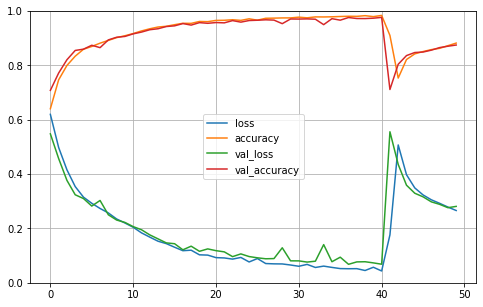

MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 18s 10ms/step - loss: 0.6566 - accuracy: 0.5943 - val_loss: 0.5661 - val_accuracy: 0.6939
Epoch 2/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.5320 - accuracy: 0.7210 - val_loss: 0.4287 - val_accuracy: 0.7958
Epoch 3/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.4033 - accuracy: 0.8102 - val_loss: 0.3389 - val_accuracy: 0.8444
Epoch 4/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.3244 - accuracy: 0.8583 - val_loss: 0.3008 - val_accuracy: 0.8666
Epoch 5/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.2752 - accuracy: 0.8844 - val_loss: 0.2506 - val_accuracy: 0.8955
Epoch 6/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.2397 - accuracy: 0.9012 - val_loss: 0.2222 - val_accuracy: 0.9062
Epoch 7/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.2099 - ac

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0435 - accuracy: 0.9813 - val_loss: 0.0505 - val_accuracy: 0.9796


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0389 - accuracy: 0.9840 - val_loss: 0.0486 - val_accuracy: 0.9794
Epoch 24/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0403 - accuracy: 0.9841 - val_loss: 0.0574 - val_accuracy: 0.9779
Epoch 25/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0391 - accuracy: 0.9833 - val_loss: 0.0529 - val_accuracy: 0.9791
Epoch 26/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0365 - accuracy: 0.9838 - val_loss: 0.0490 - val_accuracy: 0.9805


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0367 - accuracy: 0.9850 - val_loss: 0.0477 - val_accuracy: 0.9797
Epoch 28/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0375 - accuracy: 0.9847 - val_loss: 0.0387 - val_accuracy: 0.9842


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0309 - accuracy: 0.9871 - val_loss: 0.0421 - val_accuracy: 0.9832
Epoch 30/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0341 - accuracy: 0.9875 - val_loss: 0.0445 - val_accuracy: 0.9828
Epoch 31/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0303 - accuracy: 0.9882 - val_loss: 0.0453 - val_accuracy: 0.9819
Epoch 32/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0284 - accuracy: 0.9884 - val_loss: 0.0379 - val_accuracy: 0.9840
Epoch 33/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0294 - accuracy: 0.9881 - val_loss: 0.0412 - val_accuracy: 0.9836
Epoch 34/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0251 - accuracy: 0.9895 - val_loss: 0.0439 - val_accuracy: 0.9839
Epoch 35/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0290 - accuracy: 0.9887 - val_loss: 0.0384 

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0229 - accuracy: 0.9909 - val_loss: 0.0406 - val_accuracy: 0.9842
Epoch 37/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0222 - accuracy: 0.9914 - val_loss: 0.0371 - val_accuracy: 0.9856


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 38/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0254 - accuracy: 0.9902 - val_loss: 0.0507 - val_accuracy: 0.9821
Epoch 39/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0208 - accuracy: 0.9916 - val_loss: 0.0433 - val_accuracy: 0.9857


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0258 - accuracy: 0.9898 - val_loss: 0.0393 - val_accuracy: 0.9859


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0171 - accuracy: 0.9938 - val_loss: 0.0524 - val_accuracy: 0.9819
Epoch 42/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0289 - accuracy: 0.9891 - val_loss: 0.0377 - val_accuracy: 0.9865


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0168 - accuracy: 0.9936 - val_loss: 0.0382 - val_accuracy: 0.9858
Epoch 44/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0190 - accuracy: 0.9926 - val_loss: 0.0529 - val_accuracy: 0.9825
Epoch 45/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.0195 - accuracy: 0.9930 - val_loss: 0.0340 - val_accuracy: 0.9884


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1334/1334 [==============================] - 12s 9ms/step - loss: 0.0177 - accuracy: 0.9940 - val_loss: 0.0308 - val_accuracy: 0.9894


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 47/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0144 - accuracy: 0.9942 - val_loss: 0.0403 - val_accuracy: 0.9870
Epoch 48/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0159 - accuracy: 0.9937 - val_loss: 0.0402 - val_accuracy: 0.9849
Epoch 49/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0169 - accuracy: 0.9932 - val_loss: 0.0329 - val_accuracy: 0.9884
Epoch 50/50
1334/1334 [==============================] - 13s 9ms/step - loss: 0.0106 - accuracy: 0.9960 - val_loss: 0.0455 - val_accuracy: 0.9845
Fold 2, 50 epochs, 806 sec


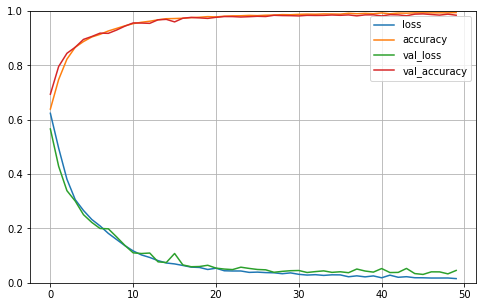

MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 18s 11ms/step - loss: 0.6599 - accuracy: 0.5870 - val_loss: 0.5742 - val_accuracy: 0.6905
Epoch 2/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.5522 - accuracy: 0.7078 - val_loss: 0.4610 - val_accuracy: 0.7807
Epoch 3/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.4120 - accuracy: 0.8074 - val_loss: 0.3303 - val_accuracy: 0.8542
Epoch 4/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.3224 - accuracy: 0.8554 - val_loss: 0.2910 - val_accuracy: 0.8693
Epoch 5/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.2823 - accuracy: 0.8743 - val_loss: 0.2787 - val_accuracy: 0.8780
Epoch 6/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.2595 - accuracy: 0.8870 - val_loss: 0.2440 - val_accuracy: 0.8934
Epoch 7/50
1334/1334 [==============================] - 13s 10ms/step - loss: 0.2330

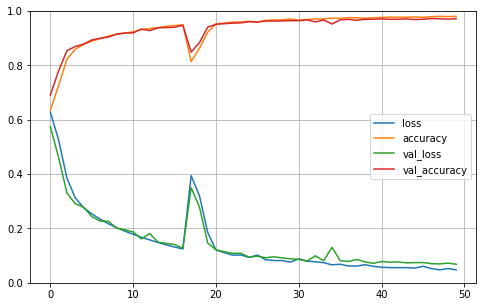

In [ ]:
do_cross_validation(X,y)

In [ ]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 98.35%


predictions.shape (2000, 1)
first prediction [0.78]


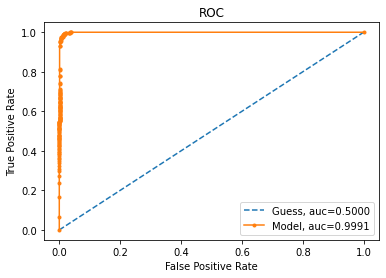

AUC: 99.91%


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
print("predictions.shape",bm_probs.shape)
print("first prediction",bm_probs[0])
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [ ]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-25 19:36:26 UTC'